# SETUP

In [ ]:
!pip install nltk
!pip install gensim
!pip install seaborn
!pip install transformers
!pip install datasets

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 40.5 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
     |████████████████████████████████| 6.6 MB 41.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 29.3 MB/s 
     |████████████████████████████████| 136 kB 58.0 MB/s 
     |████████████████████████████████| 212 kB 50.8 MB/s 
     |████████████████████████████████| 127 kB 44.6 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 47.7 MB/s 
     |████████████████████████████████| 94 kB 1.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

In [ ]:
import numpy as np
import sklearn
import gensim
import pandas as pd
import torch
import threading                 # For multi-threading

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# constants and global variables
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Dataset/{}'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Models/{}'
TENSOR_BOARD_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Tensorboard/{}'

# if set to true the trainig of the classifier models will be performed, otherwise the 
# models will be loaded from a file (if present)
is_train_enabled = True
# if set to True the preprocessing for the bert models will be performed.
# if set to False the preprocessing for TD_IDF/W2V will be performed
is_bert_preprocessing_enabled = False
# if set to true the trainig of the W2V model will be performed, otherwise the 
# model will be loaded from a file (if present)
is_w2v_train_enabled = False

In [ ]:
# Clear the logs of previous runs of tensorboard
!rm -rf /content/drive/MyDrive/Colab\ Notebooks/CIL/Tensorboard/*

# Tensorboard
from torch.utils.tensorboard import SummaryWriter

training_writer = SummaryWriter(TENSOR_BOARD_PATH.format("/train"))
validation_writer = SummaryWriter(TENSOR_BOARD_PATH.format("/valid"))

# READ DATA

In [ ]:
tweets = []
labels = []

def load_tweets(filename, label):
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            tweets.append(line.rstrip())
            labels.append(label)

# load training tweets   
load_tweets(DATA_PATH.format('train_neg_full.txt'), 0)
load_tweets(DATA_PATH.format('train_pos_full.txt'), 1)
# Convert to NumPy array to facilitate indexing
print(f'{len(tweets)} training/dev tweets loaded')
tweets = np.array(tweets)
labels = np.array(labels)

# load the test file
f = open(DATA_PATH.format('test_data.txt'), 'r', encoding='utf-8')
X_test = []
for line in f:
  X_test.append(line.split(',')[1].rstrip())
X_test = np.array(X_test)
print(f'{len(X_test)} test tweets loaded')


for i in range(10):
    print(tweets[i])
    print(labels[i])

for i in range(10):
  print(X_test[i])

2500000 training/dev tweets loaded
10000 test tweets loaded
vinco tresorpack 6 ( difficulty 10 of 10 object : disassemble and reassemble the wooden pieces this beautiful wo ... <url>
0
glad i dot have taks tomorrow ! ! #thankful #startho
0
1-3 vs celtics in the regular season = were fucked if we play them in the playoffs
0
<user> i could actually kill that girl i'm so sorry ! ! !
0
<user> <user> <user> i find that very hard to believe im afraid
0
wish i could be out all night tonight ! <user>
0
<user> i got kicked out the wgm
0
rt <user> <user> <user> yes she is ! u tell it ! my lips are closed okay
0
why is she so perfect <url>
0
<user> hi harry ! did u havea good time in aus ? i didnt get 2 see u maybe next year ! follow me back if u can , would bea dreamcome truex
0
sea doo pro sea scooter ( sports with the portable sea-doo seascootersave air
<user> shucks well i work all week so now i can't come cheer you on ! oh and put those batteries in your calculator ! ! !
i cant stay away fro

# Preprocessing
perform cleaning and tokenization of the data set. There are two different routines, one for the standard machine learning models (trees, svc, mlp, etc...) and one for the bert models

In [ ]:
from transformers import AutoTokenizer

# built-in tokenization function for the pretrained BERT models
def tokenize_function(tweet):
    return tokenizer(tweet, padding=True, truncation=True, max_length=30)

In [ ]:
# preprocessing for the bert models 
if is_bert_preprocessing_enabled:
  
  # Lowercasing sentence
  tweets = list(map(lambda tweet : tweet.lower(), tweets))
  X_test = list(map(lambda tweet : tweet.lower(), X_test))

  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
  tweets = tweets.map(tokenize_function, batched=True)
  X_test = X_test.map(tokenize_function, batched=True)

In [ ]:
# preprocessing for the non bert models
if not is_bert_preprocessing_enabled:
  # Lowercasing sentence
  tweets = list(map(lambda tweet : tweet.lower(), tweets))
  X_test = list(map(lambda tweet : tweet.lower(), X_test))

  # TODO: remove url, user, link and numbers and other common words

  from nltk.tokenize import RegexpTokenizer
  # Tokenizing sentence
  tokenizer = RegexpTokenizer(r'\w+')
  tweets = list(map(lambda tweet : tokenizer.tokenize(tweet), tweets))
  X_test = list(map(lambda tweet : tokenizer.tokenize(tweet), X_test))

  from nltk.corpus import stopwords
  # Removing stopwords
  stopwords_set = stopwords.words('english')
  tweets = list(map(lambda tweet  : [w for w in tweet if not w in stopwords_set], tweets))
  X_test = list(map(lambda tweet  : [w for w in tweet if not w in stopwords_set], X_test))

  from nltk.stem import WordNetLemmatizer
  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  tweets = list(map(lambda tweet : [lemmatizer.lemmatize(w) for w in tweet], tweets))
  X_test = list(map(lambda tweet : [lemmatizer.lemmatize(w) for w in tweet], X_test))

  # TODO: detect bigrams

In [ ]:
for i in range(20):
  print(tweets[i])

print("\n\n\n")

for i in range(20):
  print(X_test[i])

['vinco', 'tresorpack', '6', 'difficulty', '10', '10', 'object', 'disassemble', 'reassemble', 'wooden', 'piece', 'beautiful', 'wo', 'url']
['glad', 'dot', 'taks', 'tomorrow', 'thankful', 'startho']
['1', '3', 'v', 'celtic', 'regular', 'season', 'fucked', 'play', 'playoff']
['user', 'could', 'actually', 'kill', 'girl', 'sorry']
['user', 'user', 'user', 'find', 'hard', 'believe', 'im', 'afraid']
['wish', 'could', 'night', 'tonight', 'user']
['user', 'got', 'kicked', 'wgm']
['rt', 'user', 'user', 'user', 'yes', 'u', 'tell', 'lip', 'closed', 'okay']
['perfect', 'url']
['user', 'hi', 'harry', 'u', 'havea', 'good', 'time', 'au', 'didnt', 'get', '2', 'see', 'u', 'maybe', 'next', 'year', 'follow', 'back', 'u', 'would', 'bea', 'dreamcome', 'truex']
['introduction', 'programming', 'c', '2nd', 'edition', 'solid', 'foundation', 'basic', 'c', 'programming', 'url']
['introduction', 'programming', 'c', '2nd', 'edition', 'solid', 'foundation', 'basic', 'c', 'programming', 'url']
['introduction', 'prog

In [ ]:
# shuffle the training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(tweets, labels, random_state=42)

# INITIAL EXPLORATION

In [ ]:
# get number of positive and negative tweets
print(f"In our dataset there are {(labels == 0).sum()} negative tweets")
print(f"In our dataset there are {(labels == 1).sum()} positive tweets")

In our dataset there are 1250000 negative tweets
In our dataset there are 1250000 positive tweets


In [ ]:
# get the average length of positive and negative examples
def get_average_length(target_label):
  len_tweets = []
  for tweet, label in zip(tweets, labels):
    if label == target_label:
      len_tweets.append(len(tweet))
  
  return np.array(len_tweets).mean()

# NOTE: postive tweets seem to be longer on average than negative tweets.
# TODO: check if this thing can be used at our advantange in training
if not is_bert_preprocessing_enabled:
  print(f"The average length of tweets with a negative sentiment is: {get_average_length(0)}")
  print(f"The average length of tweets with a positive sentiment is: {get_average_length(1)}")

The average length of tweets with a negative sentiment is: 9.7352336
The average length of tweets with a positive sentiment is: 7.4341976


In [ ]:
# get most frequent words in positive and negative examples
def count_words(target_label):
  words_occurrences = {}
  for tweet, label in zip(tweets, labels):
    if label == target_label:
      for word in tweet:
        words_occurrences[word] = words_occurrences.get(word, 0) + 1

  return words_occurrences


from collections import Counter

if not is_bert_preprocessing_enabled:
  # negative tweets
  print("NEGATIVE TWEETS:")
  negative = count_words(0)
  print(dict(Counter(negative).most_common(100)))
  # print uniques words in the negative tweets
  print(len(negative))

  # positive tweets
  print("\n\n\n POSITIVE TWEETS:")
  positive = count_words(1)
  print(dict(Counter(positive).most_common(100)))
  # print uniques words in the positive tweets
  print(len(positive))

NEGATIVE TWEETS:
{'user': 579290, 'url': 428041, 'frame': 102464, '2': 59746, '1': 59459, 'rt': 56658, 'like': 55673, '3': 54515, 'u': 52488, 'get': 52067, 'go': 50980, 'one': 48103, 'want': 45193, 'paperback': 43726, 'miss': 42609, 'know': 42561, 'day': 38829, 'really': 36500, 'time': 35358, 'love': 34868, 'pack': 32850, 'black': 32752, 'see': 32029, 'x': 31429, 'please': 31428, '5': 31329, 'complete': 31283, 'back': 31109, '4': 30968, 'picture': 30957, 'need': 30432, 'lol': 30146, 'wish': 29888, 'got': 28315, 'im': 28047, 'going': 27808, 'today': 27585, 'wide': 27324, 'feel': 26855, 'poster': 26620, 'new': 26317, 'custom': 26146, 'make': 24955, 'sad': 24903, 'think': 24530, '8': 24527, 'work': 24335, 'good': 24202, 'come': 23695, 'never': 23377, 'much': 23338, 'still': 23055, 'edition': 22846, 'hate': 22774, '6': 22597, 'follow': 21341, 'home': 20523, 'wanna': 20324, 'would': 20053, 'sorry': 19781, 'friend': 19595, 'right': 19427, 'life': 19338, 'year': 19174, 'book': 18919, 'school'

# Words embeddings

## TF-IDF

In [ ]:
# TODO

## W2V

In [ ]:
from gensim.models import Word2Vec
import multiprocessing

# Count the number of cores in the computer
cores = multiprocessing.cpu_count()
print(cores)

# define the  W2V model
# TODO: experiment with different hyperparameters
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=220,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5,
                     workers=cores-1)

4


In [ ]:
#  build the vocabulary table
if is_w2v_train_enabled:
  w2v_model.build_vocab(X_train)

In [ ]:
if is_w2v_train_enabled:
  # train the model
  w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  
  # since we don't plan to train the model any further, we use this function to make the model more memory efficient
  w2v_model.init_sims(replace=True)

  # save the model to a file so that it can be reused without being trained from scratch
  w2v_model.save(MODEL_PATH.format("word2vec_200.model"))

In [ ]:
# load the trained model
w2v_model = Word2Vec.load(MODEL_PATH.format("word2vec_200.model"))

### Data Visualization

In [ ]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["lol"])

[('lmao', 0.8865727186203003),
 ('tho', 0.8333746790885925),
 ('haha', 0.7717642188072205),
 ('lmfao', 0.7281587719917297),
 ('yea', 0.7275999188423157),
 ('thats', 0.7223934531211853),
 ('cuz', 0.7182134389877319),
 ('hahaha', 0.7142066955566406),
 ('shit', 0.709229052066803),
 ('smh', 0.6982873678207397)]

In [ ]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["war"])

[('wwii', 0.5806748867034912),
 ('civil', 0.5701678395271301),
 ('napoleonic', 0.5542724132537842),
 ('1945', 0.5520930290222168),
 ('boer', 0.5484464168548584),
 ('soviet', 0.5306030511856079),
 ('warfare', 0.5247260332107544),
 ('1943', 0.5238946676254272),
 ('1939', 0.5214782953262329),
 ('crusade', 0.5192654132843018)]

In [ ]:
# check which words are most similar to
w2v_model.wv.most_similar(positive=["email"])

[('message', 0.6152521371841431),
 ('dm', 0.5976051092147827),
 ('fanmail', 0.5599991083145142),
 ('mail', 0.5475662350654602),
 ('msg', 0.5178768038749695),
 ('emailed', 0.5144924521446228),
 ('hotmail', 0.5121719837188721),
 ('inbox', 0.5073807835578918),
 ('info', 0.5003353357315063),
 ('send', 0.49818187952041626)]

In [ ]:
# return a number representing how much these two words are similar
w2v_model.wv.similarity("lol", 'haha')

0.7717642

In [ ]:
# return the word that is least similar to the others in the list
w2v_model.wv.doesnt_match(['lol', 'haha', 'sad'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'sad'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# draw words on a graph. Similar words  are close together in the graph.
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, w2v_model.vector_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


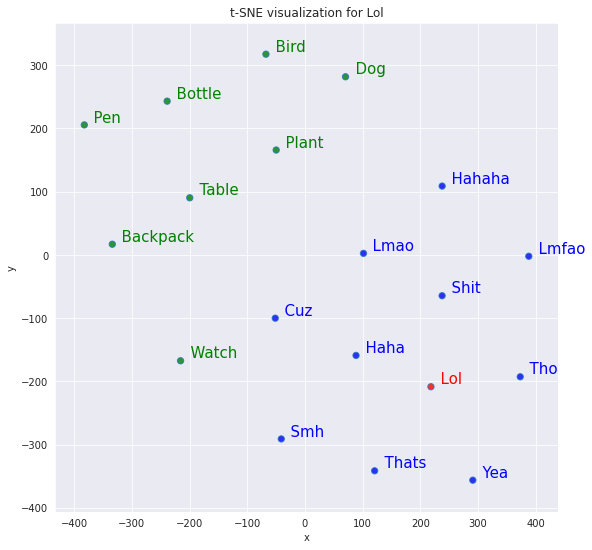

In [ ]:
# visualize the 10 most similar words to doctor and 8 random words
tsnescatterplot(w2v_model, 'lol', ['dog', 'bird', 'table', 'watch', 'pen', 'plant', 'bottle', 'backpack'])

## Sentence Embeddings

In [ ]:
# given a list of sentences, for each sentence compute its emebedding by
# computing the embedding of each word in the sentence and then divide by the
# length of the phrase
def generate_senteces_embeddings(X):
  
  sentences_embedding = []
  # for each sentence in the set
  for sentence in X:
    sentence_length = len(sentence)
    # this variable will hold the sum of each word embedding in the current phrase
    sentence_embedding = np.zeros(w2v_model.vector_size)
    # for each word in the sentence
    for word in sentence:
      # embedding of the current word
      word_embedding = np.zeros(w2v_model.vector_size)

      # compute the embedding of the current word. This is not always possible as
      # not every word is in our dictionary. If this is not possible I simply discard
      # the word and decrese the sentence length by 1. 
      try:
        word_embedding = w2v_model.wv[word]
      except KeyError:
        sentence_length = sentence_length - 1
      
      sentence_embedding = sentence_embedding + word_embedding 
    
    # in our dataset there are some (very few) length 1 sentences
    # with one single word that is not part of the model vocabulary.
    # In order to prevent a divison by 0, this if stattement is necessary.
    if sentence_length == 0:
      sentence_embedding = np.zeros(w2v_model.vector_size)
    else:
      sentence_embedding = sentence_embedding / sentence_length

    # add the sentence embedding to the list that will be returned
    sentences_embedding.append(np.array(sentence_embedding))
  

  return sentences_embedding

X_train = np.array(generate_senteces_embeddings(X_train))
X_test = np.array(generate_senteces_embeddings(X_test))

# General Models
Apply standard machine learning models to the words embeddings that come out of TF-IDF and W2V.

## Multi Layer Perceptron
(pytorch)

In [ ]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}.")

Device is cuda.


In [ ]:
from sklearn.model_selection import train_test_split

# split the model into training test and validation
X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X_train, y_train, test_size=0.20, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=33)

# Boiler plate code for Pytorch...:

# create tensor for the training data
X_train = torch.tensor(X_train, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
# create tensor for the test data
X_test_tmp = torch.tensor(X_test_tmp, device=device).float()
y_test_tmp = torch.tensor(y_test_tmp, device=device).float()
# create tensor for the validation data
X_val = torch.tensor(X_val, device=device).float()
len_validation_set = len(X_val)
y_val = torch.tensor(y_val, device=device).float()

# create datasets 
training_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test_tmp, y_test_tmp)
val_set = torch.utils.data.TensorDataset(X_val, y_val)

batch_size = 128
# create dataloader for training test and validation datasets 
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        # input layer
        self.fc1 = nn.Linear(w2v_model.vector_size, 512)
        self.fc2 = nn.Linear(512, 512)
        # hidden layers
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(64, 32)
        self.fc10 = nn.Linear(32, 32)

        # output layer
        self.fc11 = nn.Linear(32,2)

        # droput layer
        self.droput = nn.Dropout(0.2)
   
        
    def forward(self,x):
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.droput(x)

        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.droput(x)

        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.droput(x)

        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))

        # add output layer
        x = self.fc11(x)
        x = torch.log_softmax(x, dim=1)
        
        return x

# initialize the NN
model = Net()
# add the device to the chosen device (GPU)
model = model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=64, bias=True)
  (fc8): Linear(in_features=64, out_features=64, bias=True)
  (fc9): Linear(in_features=64, out_features=32, bias=True)
  (fc10): Linear(in_features=32, out_features=32, bias=True)
  (fc11): Linear(in_features=32, out_features=2, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [ ]:
# Keep track of the numbers of epochs executed so far
NUM_EPOCH = 0
NUM_STEPS = 0

# Loss: Cross-Entropy
cross_entropy_loss = torch.nn.CrossEntropyLoss()

# count total number of parameters including non trainable
total_params_count = sum(p.numel() for p in model.parameters())
# count total trainable parameters
trainable_params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of trainable parameters: {total_params_count}")
print(f"Number of trainable parameters: {trainable_params_count}")

# Optimizer: Adam 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of trainable parameters: 627714
Number of trainable parameters: 627714


In [ ]:
# Train model for 1 epoch.
def train_step():

    global NUM_STEPS

    # put the model in training mode
    model.train()

    for i, (tweet, label) in enumerate(train_loader):
        label = label.type(torch.LongTensor)              # casting to long
        tweet, label = tweet.to(device), label.to(device) # put the data on the selected execution device
        optimizer.zero_grad()                             # zero the parameter gradients
        output = model(tweet)                             # forward pass
        loss = cross_entropy_loss(output, label)          # compute loss
        loss.backward()                                   # backward pass
        optimizer.step()                                  # perform update
        
        NUM_STEPS += 1
        # log summaries to training_writer
        training_writer.add_scalar('loss', loss.item(), NUM_STEPS)

        train_accuracy = (torch.argmax(output, dim=1) == label).float().sum() / len(label) # get the accuracy for the batch
        training_writer.add_scalar('accuracy', train_accuracy, NUM_STEPS)
    
    return loss, train_accuracy

# Evaluate model on validation data.
def evaluate():

    model.eval()
    total_loss, total_accuracy = 0., 0.
    
    with torch.no_grad():
        for i, (tweet, label) in enumerate(val_loader):
            label = label.type(torch.LongTensor)
            tweet, label = tweet.to(device), label.to(device) # put the data on the selected execution device
            output = model(tweet)                             # forward pass
            loss = cross_entropy_loss(output, label)          # compute loss

            total_loss += loss.item()
            total_accuracy += (torch.argmax(output, dim=1) == label).float().sum()
        
    total_loss /= len(val_loader)
    total_accuracy /= len_validation_set

    return total_loss, total_accuracy

# Train model on entire dataset
def train(n_epochs):

    # use the global NUM_STEPS, NUM_EPOCH variable
    global NUM_STEPS, NUM_EPOCH
    
    # variables for early stopping
    last_accuracy = 0
    patience = 5
    trigger_times = 0

    for epoch in range(n_epochs):
        
        # train model for one epoch
        train_loss, train_accuracy = train_step()
        
        # Tensorboard loop
        for name, weight in model.named_parameters():
            # Attach a lot of summaries to training_writer for TensorBoard visualizations.
            training_writer.add_scalar(f'{name}.mean', torch.mean(weight), NUM_EPOCH)
            training_writer.add_scalar(f'{name}.std_dev', torch.std(weight), NUM_EPOCH)
            training_writer.add_scalar(f'{name}.max', torch.max(weight), NUM_EPOCH)
            training_writer.add_scalar(f'{name}.min', torch.min(weight), NUM_EPOCH)
            training_writer.add_histogram(f'{name}.weights', weight, NUM_EPOCH)
            training_writer.add_histogram(f'{name}.grad', weight.grad, NUM_EPOCH)

        # evaluate 
        val_loss, val_accuracy = evaluate()

        # early stopping condition
        if val_accuracy <= last_accuracy:
            trigger_times += 1
            if trigger_times >= patience:
                break
        else:
            trigger_times = 0

        last_accuracy = val_accuracy

        # log summaries to validation_writer
        validation_writer.add_scalar('loss', val_loss, NUM_STEPS)
        validation_writer.add_scalar('accuracy', val_accuracy, NUM_STEPS)

        print(f"[Epoch {NUM_EPOCH}] - Training : accuracy = {train_accuracy}, loss = {train_loss}", end=" ")
        print(f"Validation : accuracy = {val_accuracy}, loss = {val_loss}")

        NUM_EPOCH += 1

In [ ]:
if is_train_enabled:
  train(2)
  training_writer.flush()
  validation_writer.flush()

  # save the model to file
  torch.save(model.state_dict(), MODEL_PATH.format("MLP_512_200_pytorch"))

  # Tensorboard
  %load_ext tensorboard
  %tensorboard --logdir /content/drive/MyDrive/Colab\ Notebooks/CIL/Tensorboard/

  training_writer.close()
  validation_writer.close()

[Epoch 0] - Training : accuracy = 0.796875, loss = 0.35319390892982483 Validation : accuracy = 0.810783326625824, loss = 0.4005408804575602
[Epoch 1] - Training : accuracy = 0.78125, loss = 0.3910152018070221 Validation : accuracy = 0.8143083453178406, loss = 0.3929742209434509
[Epoch 2] - Training : accuracy = 0.8359375, loss = 0.3295382559299469 Validation : accuracy = 0.8165749907493591, loss = 0.38795336909294126


In [ ]:
# load the model fromt the corresponding path
model.load_state_dict(torch.load(MODEL_PATH.format('MLP_512_200_pytorch')))

### KERAS ❤️
Same model implemented above but with Keras, in 1/3 od the lines... 🥲

In [ ]:
from sklearn.model_selection import train_test_split

# split the model into training test and validation
X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X_train, y_train, test_size=0.20, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=33)


In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, input_dim=w2v_model.vector_size, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

tensorflow.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.count_params()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               113152    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)              

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

file_path = MODEL_PATH.format("MLP_w2v_220_512.h5")
callbacks = [
             ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
             ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2),
             EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
             ]
if is_train_enabled:
  history = model.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.10, callbacks=callbacks, batch_size=128)

Epoch 1/5
12368/12375 [============================>.] - ETA: 0s - loss: 0.4156 - accuracy: 0.8019
Epoch 1: val_accuracy improved from -inf to 0.81065, saving model to /content/drive/MyDrive/Colab Notebooks/CIL/Models/MLP_w2v_220_512.h5
12375/12375 [==============================] - 38s 3ms/step - loss: 0.4156 - accuracy: 0.8019 - val_loss: 0.4021 - val_accuracy: 0.8107 - lr: 0.0010
Epoch 2/5
12367/12375 [============================>.] - ETA: 0s - loss: 0.3951 - accuracy: 0.8128
Epoch 2: val_accuracy improved from 0.81065 to 0.81553, saving model to /content/drive/MyDrive/Colab Notebooks/CIL/Models/MLP_w2v_220_512.h5
12375/12375 [==============================] - 36s 3ms/step - loss: 0.3951 - accuracy: 0.8128 - val_loss: 0.3909 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 3/5
12358/12375 [============================>.] - ETA: 0s - loss: 0.3857 - accuracy: 0.8179
Epoch 3: val_accuracy did not improve from 0.81553
12375/12375 [==============================] - 36s 3ms/step - loss: 0.3857 

In [ ]:
# load the model from the corresposning h5 file
model.load_weights(MODEL_PATH.format("MLP_w2v_220_512.h5"))

NameError: ignored

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

y_pred = np.argmax(model.predict(X_test_tmp), axis=-1)

f1 = f1_score(y_test_tmp, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test_tmp, y_pred)
print("Test accuracy score : %s "% acc)

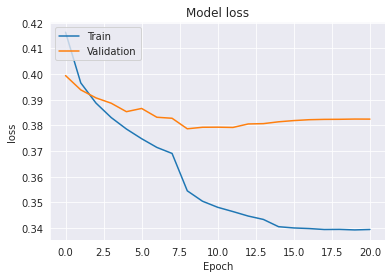

In [ ]:
if is_train_enabled:
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

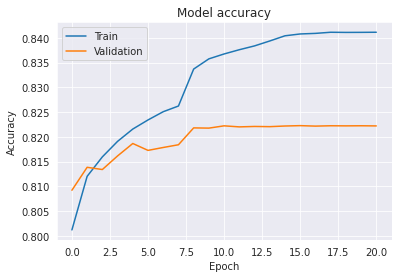

In [ ]:
if is_train_enabled:
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

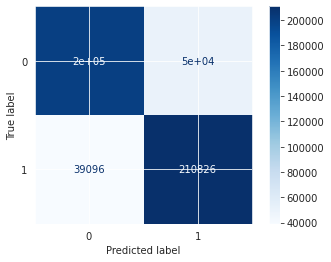

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Plotting confusion matrix
cm = confusion_matrix(y_test_tmp, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()

# Pre-trained BERT models

In [ ]:
# TODO
if is_train_enabled:
  pass